<a href="https://colab.research.google.com/github/gorleramyasri/Thesis/blob/main/LSTM_MLPERF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fri Mar 29 16:55:07 2024
@author: user
"""

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

def scaling(df, numeric_columns):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df[numeric_columns])
    df_scaled = pd.DataFrame(df_scaled, columns=numeric_columns)
    return df_scaled, scaler

def define_model(win_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(win_length, num_features)),
        tf.keras.layers.LSTM(32, return_sequences=False),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1)
    ])
    return model

# 1. Loading CSV file
path = "/content/drive/MyDrive/MTECH2YPROJECT/MTech2y/DataAnalysis/Datastes/large_dataset.csv"
df = pd.read_csv(path)
# 2. Doing modifications on DataFrame
numeric_columns = ['Eff Freq', 'Branch Misprediction Ratio', 'IC (32B) Fetch Miss Ratio',
                   'Op Cache (64B) Fetch Miss Ratio', 'IC Access (pti)', 'IC Miss (pti)',
                   'DC Access (pti)', 'L2 Access (pti)', 'L2 Access from IC Miss (pti)',
                   'L2 Access from DC Miss (pti)', 'L2 Access from HWPF (pti)', 'L2 Miss (pti)',
                   'L2 Miss from IC Miss (pti)', 'L2 Miss from DC Miss (pti)', 'L2 Miss from HWPF (pti)',
                   'L3 Access', 'L3 Miss', 'Ave L3 Miss Latency', 'IPC (Sys + User)']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# 3. Scaling to Min-Max
df_scaled, scaler = scaling(df, numeric_columns)

# 4. & 5. Using LSTM model and training data
win_length = 200
batch_size = 16
num_features = len(numeric_columns) - 1  # Excluding the target variable

# Splitting data
features = df_scaled[numeric_columns[:-1]].values
target = df_scaled['IPC (Sys + User)'].values
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=123, shuffle=False)

# Generating time series data
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

# Defining the model
model = define_model(win_length, num_features)
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.MeanAbsoluteError()])

# Training the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')
history = model.fit(train_generator, epochs=10, validation_data=test_generator, shuffle=False, callbacks=[early_stopping])
# Save the entire model to a HDF5 file
#model.save("/content/drive/MyDrive/MTECH2YPROJECT/Data_Analysis/lstm_model.h5")

# 6. Evaluating and prediction
evaluation_result = model.evaluate(test_generator, verbose=0)
print("loss:", evaluation_result[0])

# Prediction
#trainp = model.predict(train_generator)
predictions = model.predict(test_generator)

# Reshape predictions array to match the expected shape
#predictions_reshaped = predictions.reshape(-1, len(numeric_columns) - 1)
df_pred = pd.concat([pd.DataFrame(x_test[win_length:]),pd.DataFrame(predictions)], axis=1)
# Reverse transforming for getting original from scaled data
rev_trans = scaler.inverse_transform(df_pred)

#original data reverse transfomration
df_org=pd.concat([pd.DataFrame(x_test[win_length:]),pd.DataFrame(y_test[win_length:])], axis=1)
rev_trans_org=scaler.inverse_transform(df_org)



#df_final = df_scaled.iloc[predictions.shape[0] * -1:]
df_final = pd.DataFrame(rev_trans_org,columns=numeric_columns)
df_final['IPC_pred'] = rev_trans[:, -1]

# 8. Plotting for comparison
df_final[['IPC (Sys + User)','IPC_pred']][0:100].plot()
plt.show()


In [ ]:
df_final.head()

,Eff Freq,Branch Misprediction Ratio,IC (32B) Fetch Miss Ratio,Op Cache (64B) Fetch Miss Ratio,IC Access (pti),IC Miss (pti),DC Access (pti),L2 Access (pti),L2 Access from IC Miss (pti),L2 Access from DC Miss (pti),L2 Access from HWPF (pti),L2 Miss (pti),L2 Miss from IC Miss (pti),L2 Miss from DC Miss (pti),L2 Miss from HWPF (pti),L3 Access,L3 Miss,Ave L3 Miss Latency,IPC (Sys + User),IPC_pred
0,199.43,0.00,0.19,0.18,72.65,13.99,512.91,93.99,52.36,19.92,23.00,16.03,1.35,2.22,12.45,424319.0,14564.0,395.49,1.39,0.781243
1,65.31,0.01,0.12,0.16,51.87,6.23,507.97,76.52,23.22,26.76,28.66,47.89,19.27,9.86,18.76,1314187.0,14185.0,865.06,0.81,0.687015
2,536.20,0.00,0.20,0.04,12.74,2.48,414.23,80.83,18.98,29.36,33.92,66.90,29.50,16.25,21.15,55577.0,3442.0,481.02,0.13,0.390618
3,52.40,0.01,0.25,0.35,235.53,59.93,603.37,22.44,6.28,8.24,8.10,28.01,7.11,15.14,5.75,76401.0,12587.0,251.23,1.06,0.608515
4,10.78,0.03,0.25,0.15,113.22,28.02,353.30,11.36,4.74,3.30,3.21,92.58,67.28,23.21,2.09,39144.0,1843.0,402.27,1.02,0.665752


<Axes: >

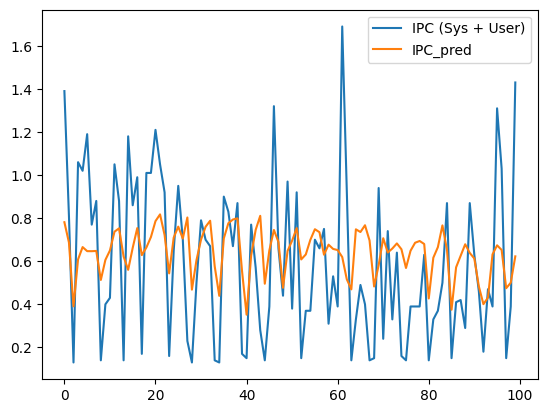

In [ ]:
df_final[['IPC (Sys + User)','IPC_pred']][0:100].plot()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')